# Roadmap

In [8]:
# imports
from functions import load_data, ts_train_test_split, make_copy_df, plot_time_series
from functions import moving_average, RMSE, rename_columns, create_fb_forecast
# functions for data import, processing, forecasting and plotting in the functions.py file
from product_segmentation_functions import identify_non_active, identify_new_product
from product_segmentation_functions import identify_intermittent_product
from product_segmentation_functions import identify_minute_demand, identify_repackage_product
from product_segmentation_functions import make_remainder_dataframe
# functions for product segmentation in segmentation_functions.py file
from clustering_functions import prep_dataframe_for_warping
# functions for clustering
from ts_cluster import ts_cluster
# this class was written by Alex Minnaar, wit

In [2]:
%load_ext autoreload
%autoreload 2
import autoreload

## 1. Load data

In [3]:
from functions import load_data
data_df = load_data('data/time_series.xlsx')
data_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 292 entries, 2012-04-08 to 2017-11-05
Columns: 1833 entries, 012 to TRUHONE
dtypes: int64(1833)
memory usage: 4.1 MB


## 2. Train-Test Split

In [4]:
# splitting into training and testing sets setting aside last year for testing
from functions import ts_train_test_split

train_df, test_df = ts_train_test_split(data_df, 52)

Observations: 292
Training Observations: 240
Testing Observations: 52


In [ ]:
# DO NOT TOUCH Test Set!!!! Data snooping no-no

### Clustering without preprocessing

In [5]:
# try clustering before segmentation
# prepare products df for timewarping
from clustering_functions import prep_dataframe_for_warping
data_arr = prep_dataframe_for_warping(train_df)

# timewarp!!!!
from ts_cluster import ts_cluster
import random
import numpy as np
from math import sqrt

cl_obj=ts_cluster(9)
cl_obj.k_means_clust(data_arr,10,4, progress=True)

iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10


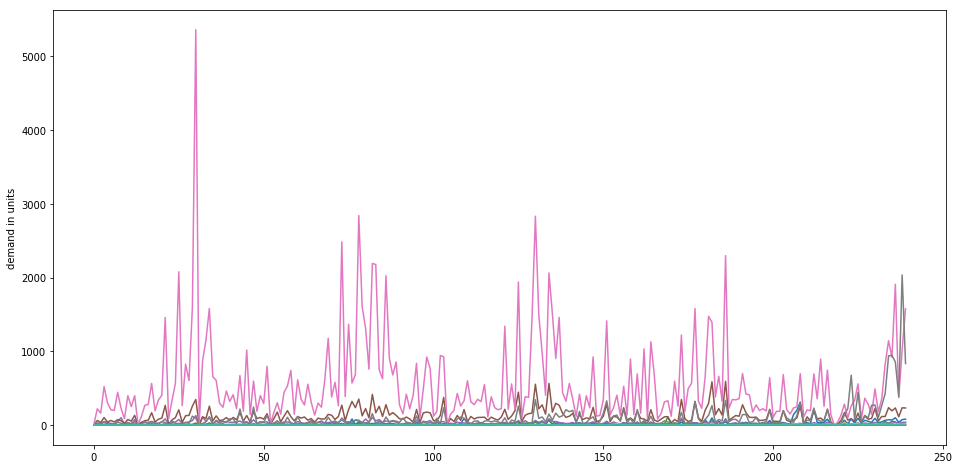

In [178]:
# plot
cl_obj.plot_centroids()

In [11]:
# save dictionary containing assignments
assigned_data = cl_obj.get_assignments()

# assign products to clusters
from clustering_functions import assign_products
from clustering_functions import make_product_dataframe

products=train_df

product_type0 = assign_products(products.T, assigned_data, 0)
product_type1 = assign_products(products.T, assigned_data, 1)
product_type2 = assign_products(products.T, assigned_data, 2)
product_type3 = assign_products(products.T, assigned_data, 3)
product_type4 = assign_products(products.T, assigned_data, 4)
product_type5 = assign_products(products.T, assigned_data, 5)
product_type6 = assign_products(products.T, assigned_data, 6)
product_type7 = assign_products(products.T, assigned_data, 7)
product_type8 = assign_products(products.T, assigned_data, 8)
#product_type9 = assign_products(products.T, assigned_data, 9)

# Make a data frame of products
type0_df = make_product_dataframe(products, product_type0, 'type 0')
type1_df = make_product_dataframe(products, product_type1, 'type 1')
type2_df = make_product_dataframe(products, product_type2, 'type 2')
type3_df = make_product_dataframe(products, product_type3, 'type 3')
type4_df = make_product_dataframe(products, product_type4, 'type 4')
type5_df = make_product_dataframe(products, product_type5, 'type 5')
type6_df = make_product_dataframe(products, product_type6, 'type 6')
type7_df = make_product_dataframe(products, product_type7, 'type 7')
type8_df = make_product_dataframe(products, product_type8, 'type 8')
#type9_df = make_product_dataframe(products, product_type9, 'type 9')

import pandas as pd 
df_new = pd.concat([type0_df, type1_df, type2_df, type3_df, type4_df, type5_df, type6_df, type7_df, type8_df])
df_new.info()

/Users/andreafabry/Documents/dsi-project/clustering_functions.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  new_df['label'] = label


<class 'pandas.core.frame.DataFrame'>
Index: 1824 entries, 1550 to 9727-1
Columns: 241 entries, 2012-04-08 00:00:00 to label
dtypes: int64(240), object(1)
memory usage: 3.4+ MB


In [12]:
# can evaluate k with Caliniski-Harabasz score
# higher the better
# add paper reference
# passing df with X
X = df_new.iloc[:, df_new.columns != 'label']
y = df_new.label

from sklearn.metrics import calinski_harabaz_score

CH_score_ns_k9 = calinski_harabaz_score(X, y)
CH_score_ns_k9

125.07734771169376

## 3. Segment Products

In [4]:
# make a list of column names
product_SKUs = list(train_df.columns.values)
len(product_SKUs)

1833

In [5]:
# non_active products
# defined as products that have not moved after a specified date

from product_segmentation_functions import identify_non_active

non_active = identify_non_active(train_df, product_SKUs, 2015, 11, 4)
len(non_active)

472

In [6]:
# new products 
from product_segmentation_functions import identify_new_product

new_products = identify_new_product(train_df, product_SKUs, 2015, 11, 4)
len(new_products)

138

In [7]:
# intermittent demand
from product_segmentation_functions import identify_intermittent_product
    
intermittent_demand = identify_intermittent_product(train_df, product_SKUs, non_active, 2015, 11, 4, 2)
len(intermittent_demand)

0

In [8]:
# products with very little demand
from product_segmentation_functions import identify_minute_demand
            
minute_demand = identify_minute_demand(train_df, product_SKUs, 30)
len(minute_demand)

681

In [9]:
# products ordered for repackaging (over 3,000 units)

from product_segmentation_functions import identify_repackage_product
repackage_product = identify_repackage_product(train_df, product_SKUs, 3000)
len(repackage_product)

43

In [10]:
# create leftover dataset for dynamic time warping
from product_segmentation_functions import make_remainder_dataframe
products = make_remainder_dataframe(train_df, product_SKUs, non_active, new_products, minute_demand, repackage_product)
products.head()

,017,0300ST1550-1,0300ST320-1,0300ST365-1,0311HT245,0311HT265,0311HT320,0311HT450,0311PARCDU,0313013,...,9888,9895,9908,9920-1,9920-2,9920-3,9920-4,9920-5,9920-6,9920-7
EntDate,,,,,,,,,,,,,,,,,,,,,
2012-04-08,0,0,0,0,0,0,0,0,0,0,...,0,0,4,0,0,0,0,0,0,0
2012-04-15,0,0,0,1,0,2,0,2,4,0,...,105,2,3,21,20,19,7,166,98,0
2012-04-22,0,0,0,0,0,0,0,0,1,0,...,6,0,4,114,41,15,10,207,87,0
2012-04-29,0,0,0,200,0,200,0,0,31,0,...,-2,1,3,43,38,44,13,101,21,10
2012-05-06,0,0,0,0,3,0,0,0,4,0,...,40,0,2,154,29,47,21,75,43,0


## K-Means Clustering with Dynamic Time Warping Distance Measure

## Prepare products dataframe for time warping

In [11]:
# prepare products df for timewarping
from product_segmentation_functions import prep_dataframe_for_warping
data_arr = prep_dataframe_for_warping(products)

In [176]:
# prepare products df for timewarping
from clustering_functions import prep_dataframe_for_warping
data_arr = prep_dataframe_for_warping(products)

# timewarp!!!!
from ts_cluster import ts_cluster
import random
import numpy as np
from math import sqrt

cl_obj=ts_cluster(10)
cl_obj.k_means_clust(data_arr,10,4, progress=True)

iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10


In [94]:
### pickle your model
from sklearn.externals import joblib

joblib.dump(cl_obj, "my_model_nsk10.pkl")

['my_modelk2.pkl']

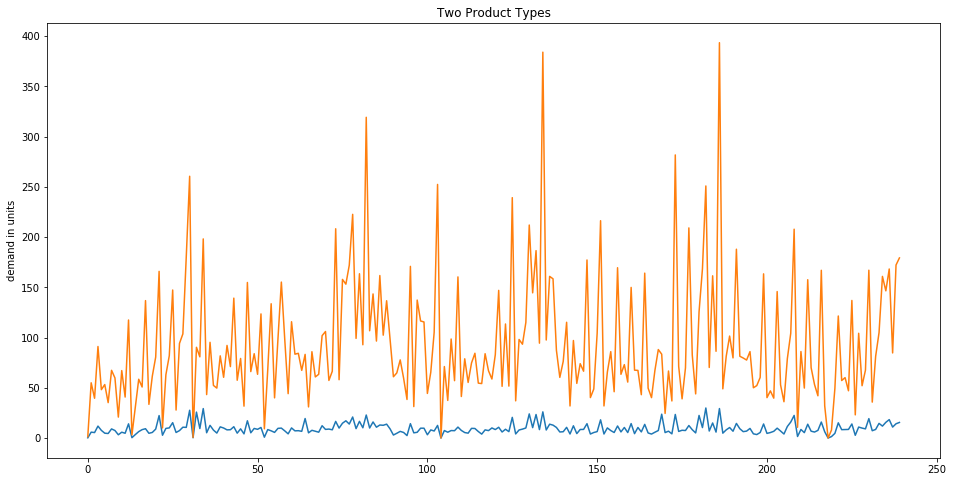

In [151]:
# plot it! save plot to send to Lee as an image
cl_obj.plot_centroids()

In [95]:
# save dictionary containing assignments
assigned_data = cl_obj.get_assignments()

In [6]:
# RUN 
# save dictionary containing assignments
assigned_data = cl_obj.get_assignments()

# assign products to clusters
from clustering_functions import assign_products

product_type0 = assign_products(products.T, assigned_data, 0)
product_type1 = assign_products(products.T, assigned_data, 1)
product_type2 = assign_products(products.T, assigned_data, 2)
product_type3 = assign_products(products.T, assigned_data, 3)
product_type4 = assign_products(products.T, assigned_data, 4)
product_type5 = assign_products(products.T, assigned_data, 5)
product_type6 = assign_products(products.T, assigned_data, 6)
product_type7 = assign_products(products.T, assigned_data, 7)
product_type8 = assign_products(products.T, assigned_data, 8)
product_type9 = assign_products(products.T, assigned_data, 9)
len(product_type0), len(product_type1), len(product_type2), len(product_type3), len(product_type4)

NameError: name 'products' is not defined

In [29]:
# save centroids
centroid0, centroid1, centroid2, centroid3, centroid4, centroid5 = cl_obj.get_centroids()

In [105]:
# save centroids
centroid0, centroid1 = cl_obj.get_centroids()

In [108]:
# RUN
# Make a data frame of products
type0_df = make_product_dataframe(products, product_type0, 'type 0')
type1_df = make_product_dataframe(products, product_type1, 'type 1')
type2_df = make_product_dataframe(products, product_type2, 'type 2')
type3_df = make_product_dataframe(products, product_type3, 'type 3')
type4_df = make_product_dataframe(products, product_type4, 'type 4')
type5_df = make_product_dataframe(products, product_type5, 'type 5')
type6_df = make_product_dataframe(products, product_type6, 'type 6')
type7_df = make_product_dataframe(products, product_type7, 'type 7')
type8_df = make_product_dataframe(products, product_type8, 'type 8')
type9_df = make_product_dataframe(products, product_type9, 'type 9')

import pandas as pd 
df_new = pd.concat([type0_df, type1_df, type2_df, type3_df, type4_df, type5_df, type6_df, type7_df, type8_df, type9_df])
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 876 entries, 0300ST1550-1 to 9920-6
Columns: 241 entries, 2012-04-08 00:00:00 to label
dtypes: int64(240), object(1)
memory usage: 1.6+ MB


/Users/andreafabry/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [167]:
# RUN 
# can evaluate k with Caliniski-Harabasz score
# higher the better
# add paper reference
# passing df with X
X = df_new.iloc[:, df_new.columns != 'label']
y = df_new.label

from sklearn.metrics import calinski_harabaz_score

CH_score_k10 = calinski_harabaz_score(X, y)
CH_score_k10

114.91409699330498

In [166]:
# create df with my segments and the two clusters
type2_df = make_product_dataframe(products, non_active, 'type 2')
type3_df = make_product_dataframe(products, new_products, 'type 3')
type4_df = make_product_dataframe(products, minute_demand, 'type 4')
type5_df = make_product_dataframe(products, repackage_product, 'type 5')

import pandas as pd 
df_new = pd.concat([type0_df, type1_df, type2_df, type3_df, type4_df, type5_df])
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1520 entries, 2944-7 to 9740-1
Columns: 241 entries, 2012-04-08 00:00:00 to label
dtypes: int64(240), object(1)
memory usage: 2.8+ MB


/Users/andreafabry/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


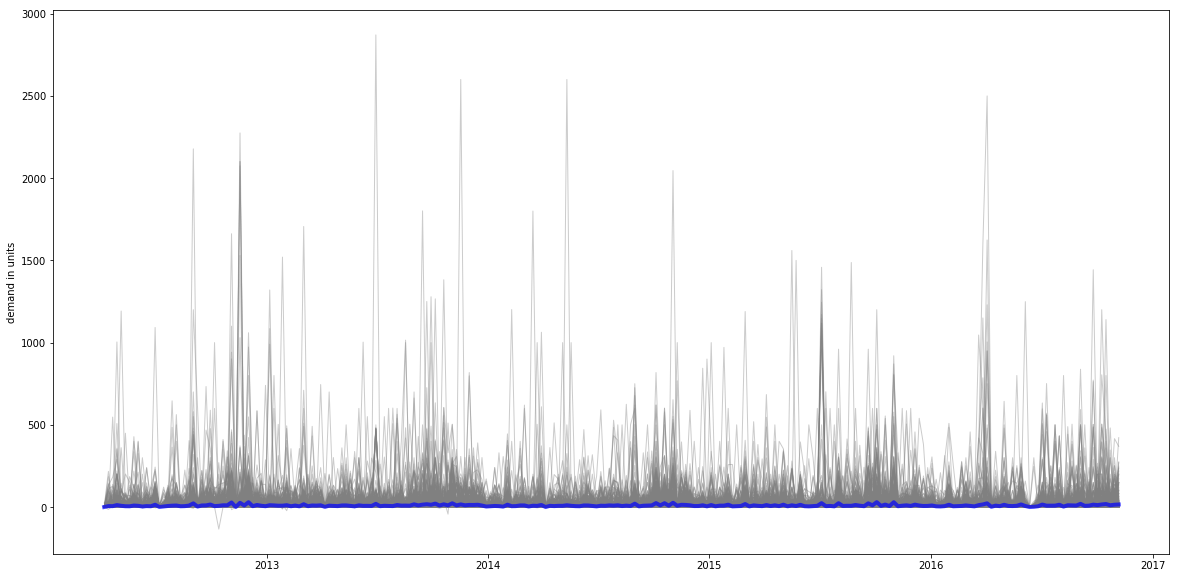

In [106]:
# product0
# imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
 
# Make a data frame of products
products_df = products.T
new_df = products_df[products_df.index.isin(product_type0)].T
col_names = new_df.columns.tolist()
new_df['centroid0'] = centroid0

plt.figure(figsize=(20,10))            
# multiple line plot
for col in col_names:
    plt.plot(new_df.index, new_df[col], marker='', color='grey', linewidth=1, alpha=0.4)

# plot centroid in different color
plt.plot(new_df.index, new_df['centroid0'], marker='', color='blue', linewidth=4, alpha=0.7)
plt.ylabel('demand in units')
#plt.xlabel()
#plt.title('Product Group #1: "Peaked in 2016"')

plt.savefig('product_cluster0.png', dpi=300)
plt.show()

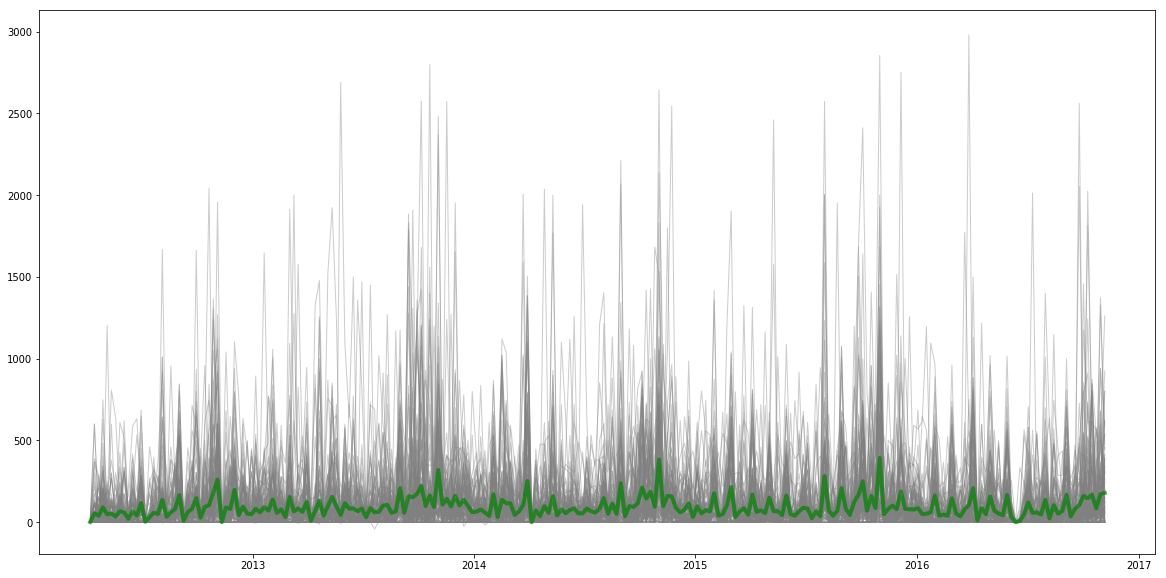

In [107]:
# product1
# imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
 
# Make a data frame of products
products_df = products.T
new_df = products_df[products_df.index.isin(product_type1)].T
col_names = new_df.columns.tolist()
new_df['centroid1'] = centroid1

plt.figure(figsize=(20,10))            
# multiple line plot
for col in col_names:
    plt.plot(new_df.index, new_df[col], marker='', color='grey', linewidth=1, alpha=0.4)

# plot centroid in different color
plt.plot(new_df.index, new_df['centroid1'], marker='', color='green', linewidth=4, alpha=0.7)

#plt.savefig('product_cluster1.png', dpi=300)
plt.show()

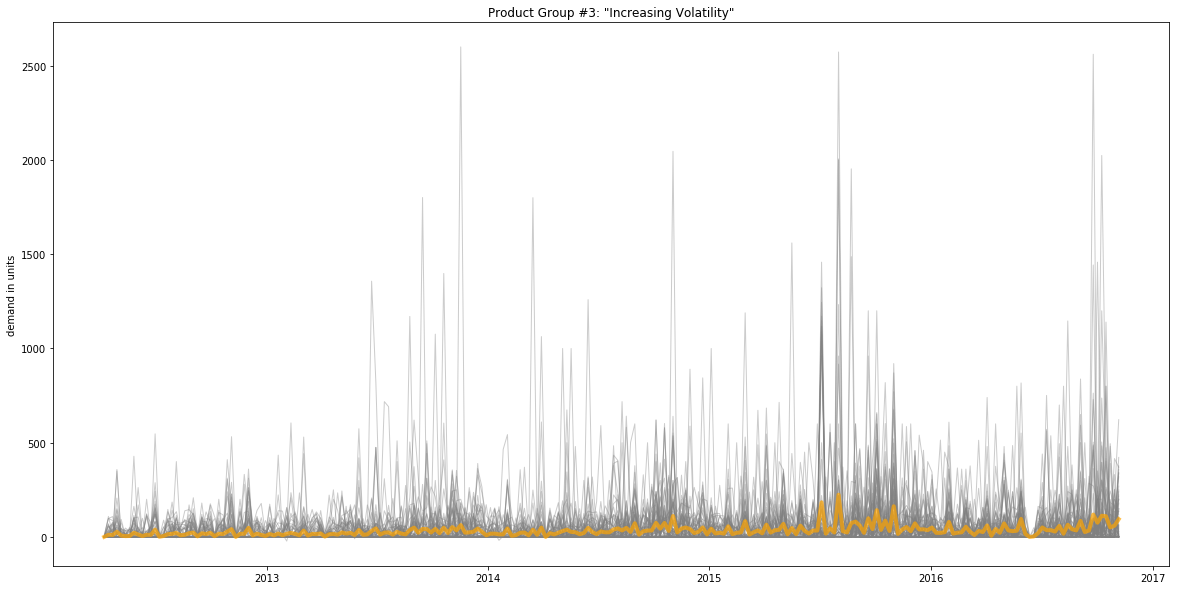

In [158]:
# Plot product clusters
# product2
# imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
 
# Make a data frame of products
products_df = products.T
new_df = products_df[products_df.index.isin(product_type2)].T
col_names = new_df.columns.tolist()
new_df['centroid2'] = centroid2

plt.figure(figsize=(20,10))            
# multiple line plot
for col in col_names:
    plt.plot(new_df.index, new_df[col], marker='', color='grey', linewidth=1, alpha=0.4)

# plot centroid in different color
plt.plot(new_df.index, new_df['centroid2'], marker='', color='orange', linewidth=4, alpha=0.7)
plt.ylabel('demand in units')
#plt.xlabel()
plt.title('Product Group #3: "Increasing Volatility"')

plt.savefig('product_cluster2.png', dpi=300)
plt.show()

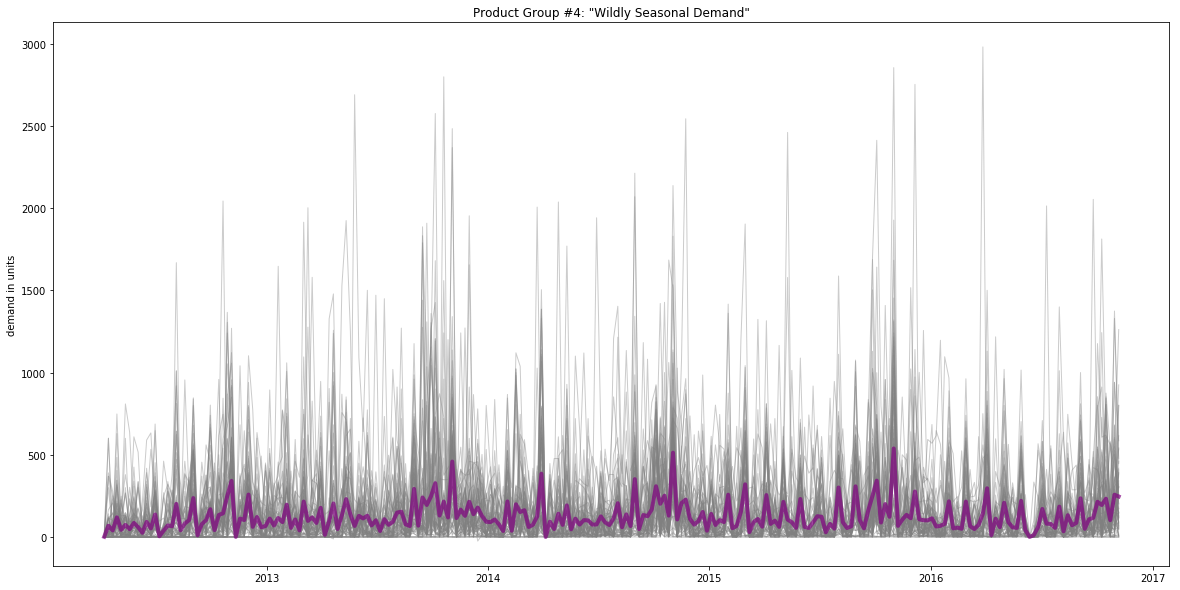

In [168]:
# Plot product clusters
# product3
# imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
 
# Make a data frame of products
products_df = products.T
new_df = products_df[products_df.index.isin(product_type3)].T
col_names = new_df.columns.tolist()
new_df['centroid3'] = centroid3

plt.figure(figsize=(20,10))            
# multiple line plot
for col in col_names:
    plt.plot(new_df.index, new_df[col], marker='', color='grey', linewidth=1, alpha=0.4)

# plot centroid in different color
plt.plot(new_df.index, new_df['centroid3'], marker='', color='purple', linewidth=4, alpha=0.7)
plt.ylabel('demand in units')
#plt.xlabel()
plt.title('Product Group #4: "Wildly Seasonal Demand"')

plt.savefig('product_cluster3.png', dpi=300)
plt.show()

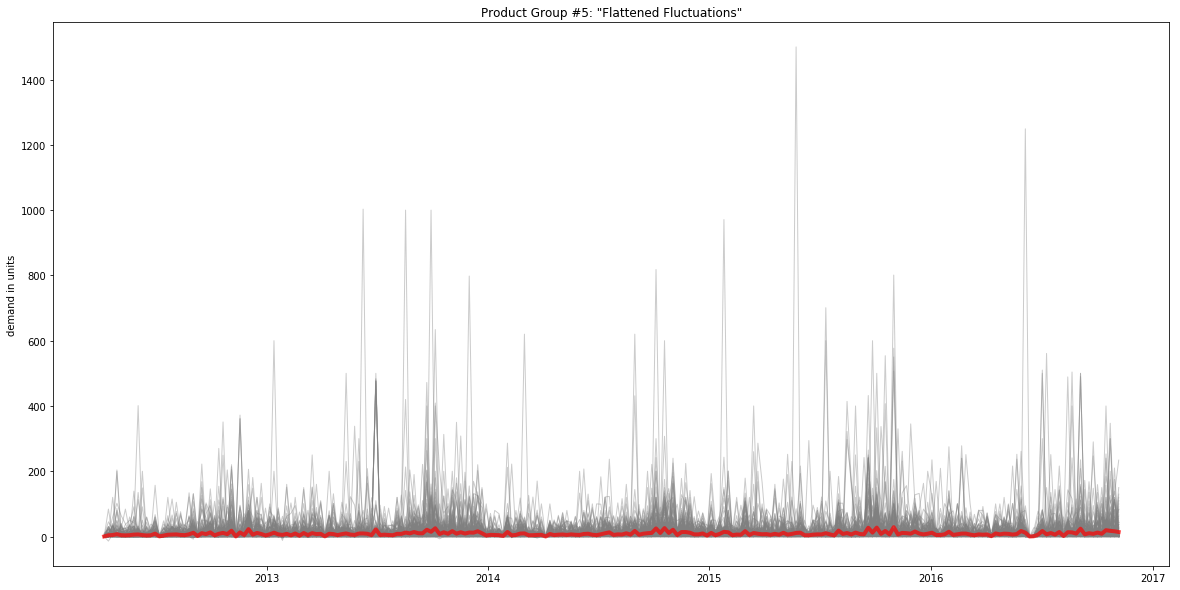

In [170]:
# product4
# imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
 
# Make a data frame of products
products_df = products.T
new_df = products_df[products_df.index.isin(product_type4)].T
col_names = new_df.columns.tolist()
new_df['centroid4'] = centroid4

plt.figure(figsize=(20,10))            
# multiple line plot
for col in col_names:
    plt.plot(new_df.index, new_df[col], marker='', color='grey', linewidth=1, alpha=0.4)

# plot centroid in different color
plt.plot(new_df.index, new_df['centroid4'], marker='', color='red', linewidth=4, alpha=0.7)
plt.ylabel('demand in units')
#plt.xlabel()
plt.title('Product Group #5: "Flattened Fluctuations"')

plt.savefig('product_cluster4.png', dpi=300)
plt.show()

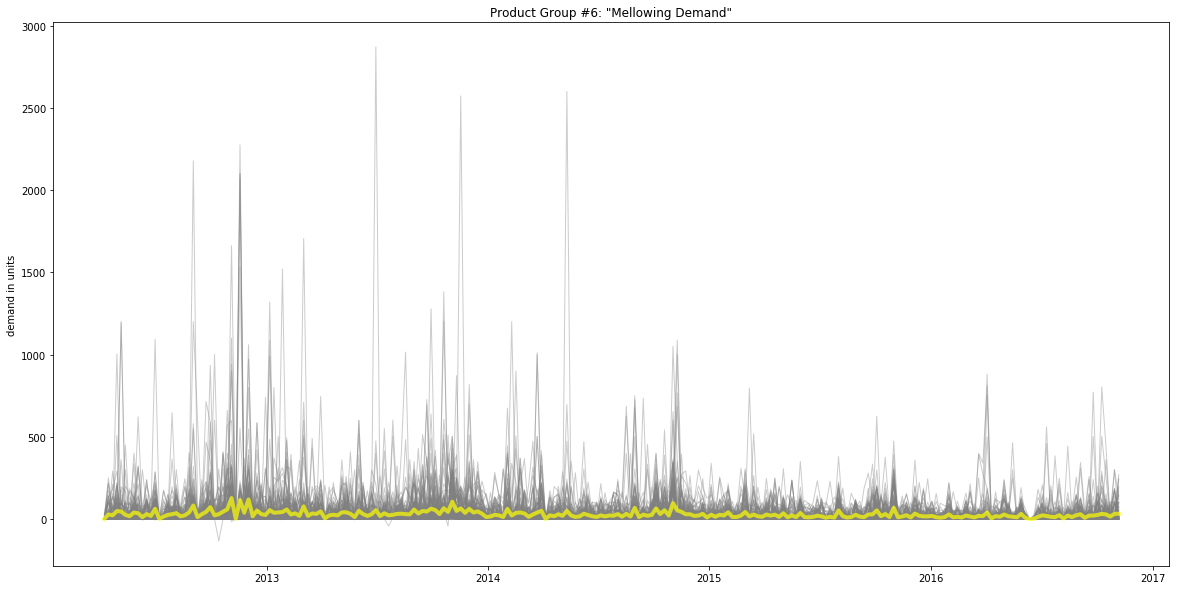

In [163]:
# product5
# imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
 
# Make a data frame of products
products_df = products.T
new_df = products_df[products_df.index.isin(product_type5)].T
col_names = new_df.columns.tolist()
new_df['centroid5'] = centroid5

plt.figure(figsize=(20,10))            
# multiple line plot
for col in col_names:
    plt.plot(new_df.index, new_df[col], marker='', color='grey', linewidth=1, alpha=0.4)

# plot centroid in different color
plt.plot(new_df.index, new_df['centroid5'], marker='', color='yellow', linewidth=4, alpha=0.7)
plt.ylabel('demand in units')
#plt.xlabel()
plt.title('Product Group #6: "Mellowing Demand"')

plt.savefig('product_cluster5.png', dpi=300)
plt.show()

Why bother? Let's look at item # 9920-2

In [154]:
# make a df to store all our predictions
from functions import make_copy_df
y_hat = make_copy_df(test_df, '9920-2')

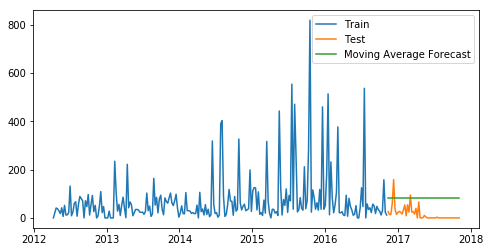

70.59469489094461

In [155]:
# baseline: Moving Average with 52
from functions import moving_average
from functions import plot_time_series
from functions import RMSE

y_hat['moving_avg'] = moving_average(train_df['9920-2'], m=52)

plot_time_series(train_df, test_df, '9920-2', y_hat, 'moving_avg', 'Moving Average Forecast')

RMSE(test_df,'9920-2', y_hat, 'moving_avg')

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/andreafabry/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


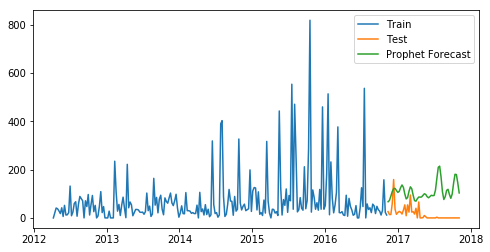

104.04466571337738

In [156]:
# FB Prophet
# imports 
from fbprophet import Prophet

# make a copy of the dataframe for Prophet transformations
from functions import make_copy_df
prophet_df = make_copy_df(train_df, '9920-2')

# rename variables (prophet requires the variable names in the time series to be
# y for target and ds for Datetime)
from functions import rename_columns
rename_columns(prophet_df, '9920-2')

# instantiate model instance and set the uncertainty interval to 95% 
# (the Prophet default is 80%)
my_model = Prophet(interval_width=0.95, weekly_seasonality=True)
# fit
my_model.fit(prophet_df)
# forecast for a year
future_dates = my_model.make_future_dataframe(periods=52, freq='W')
forecast = my_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
forecast = forecast.set_index('ds')
forecast_slice=forecast[240:292]
forecast_df = forecast_slice["yhat"]
# plot
plot_time_series(train_df, test_df, '9920-2', forecast_slice, 'yhat', 'Prophet Forecast')

RMSE(test_df, '9920-2', forecast_slice, 'yhat')

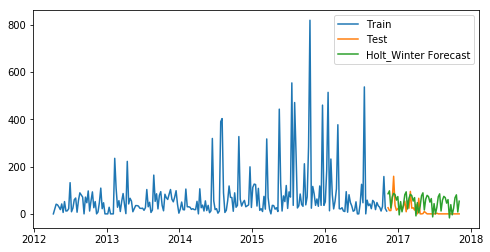

51.35384040458961

In [157]:
# Holt-Winters
# here we have trend and seasonality, so we will use Holt-Winters with Statsmodels
# additive trend and seasonality, no trend damping, seasonal periods=12
import numpy as np
from statsmodels.tsa.api import ExponentialSmoothing

fit1 = ExponentialSmoothing(np.asarray(train_df['9920-2']), seasonal_periods=12, 
                            trend='additive', seasonal='additive').fit(smoothing_level=0.51, 
                                                             smoothing_slope=0.015,
                                                             smoothing_seasonal=0.1)
y_hat['Holt_Winter'] = fit1.forecast(len(test_df))

# plot
plot_time_series(train_df, test_df, '9920-2', y_hat, 'Holt_Winter', 'Holt_Winter Forecast')

# calculate RMSE
RMSE(test_df,'9920-2', y_hat, 'Holt_Winter')

## 4. Forecast

### product_type0 (jagged line)

In [114]:
product_type0

['0300ST1550-1',
 '0300ST320-1',
 '0300ST365-1',
 '0311HT245',
 '0311HT265',
 '0311HT320',
 '0311HT450',
 '0311PARCDU',
 '0313013',
 '0313014',
 '0313015',
 '03132403B',
 '03132410B',
 '03138500FC',
 '03139800LB1C',
 '03139800MPK',
 '0313FC245CP',
 '0313FC320',
 '0313FC365',
 '0313FC450',
 '0314FT245-1',
 '0314FT320-1',
 '0314FT320-2',
 '0314FT365-1',
 '0314FT365-2',
 '0314FT450-2',
 '03159800-13',
 '03159800-14',
 '03159800-15WHT',
 '03159800-18',
 '03159800-20',
 '03159815MBX',
 '03159820MBX',
 '03159860MBX',
 '1605',
 '1606',
 '1608',
 '1700',
 '1814-200',
 '1814/23',
 '2003',
 '2037',
 '2038',
 '2039',
 '2103',
 '2252',
 '2263',
 '2263-100',
 '2265',
 '2265-100',
 '2267',
 '2267-100',
 '2267-4',
 '2267-4-100',
 '2267-5',
 '2267-5-100',
 '24-1',
 '2408',
 '2504',
 '2505',
 '2506',
 '2510',
 '2513',
 '2705',
 '2708',
 '2752',
 '2755',
 '2756',
 '2757',
 '2776',
 '2778',
 '2779',
 '2801',
 '2843',
 '2855',
 '2857',
 '2887',
 '2894',
 '2896',
 '2899R',
 '2922',
 '2927',
 '2933-B',
 '29

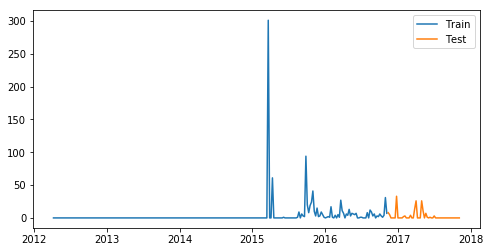

In [135]:
# plot one item
from functions import plot_train_test
plot_train_test(train_df, test_df, '7383')

In [136]:
# make a df to store all our predictions
from functions import make_copy_df
y_hat = make_copy_df(test_df, '7383')

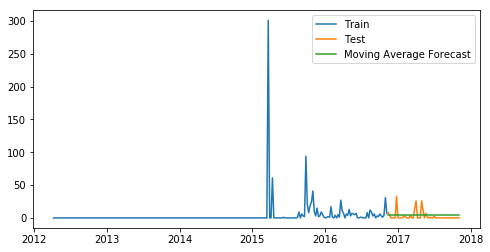

7.350507167624679

In [137]:
# baseline: Moving Average with 52
from functions import moving_average
from functions import plot_time_series
from functions import RMSE

y_hat['moving_avg'] = moving_average(train_df['7383'], m=52)

plot_time_series(train_df, test_df, '7383', y_hat, 'moving_avg', 'Moving Average Forecast')

RMSE(test_df,'7383', y_hat, 'moving_avg')

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/andreafabry/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


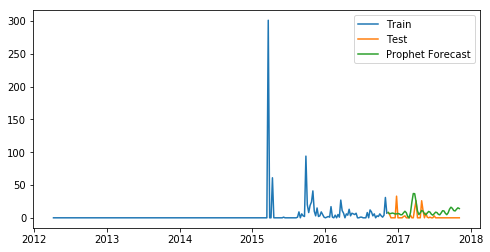

11.121373564242814

In [138]:
# FB Prophet
# imports 
from fbprophet import Prophet

# make a copy of the dataframe for Prophet transformations
from functions import make_copy_df
prophet_df = make_copy_df(train_df, '7383')

# rename variables (prophet requires the variable names in the time series to be
# y for target and ds for Datetime)
from functions import rename_columns
rename_columns(prophet_df, '7383')

# instantiate model instance and set the uncertainty interval to 95% 
# (the Prophet default is 80%)
my_model = Prophet(interval_width=0.95, weekly_seasonality=True)
# fit
my_model.fit(prophet_df)
# forecast for a year
future_dates = my_model.make_future_dataframe(periods=52, freq='W')
forecast = my_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
forecast = forecast.set_index('ds')
forecast_slice=forecast[240:292]
forecast_df = forecast_slice["yhat"]
# plot
plot_time_series(train_df, test_df, '7383', forecast_slice, 'yhat', 'Prophet Forecast')

RMSE(test_df, '7383', forecast_slice, 'yhat')

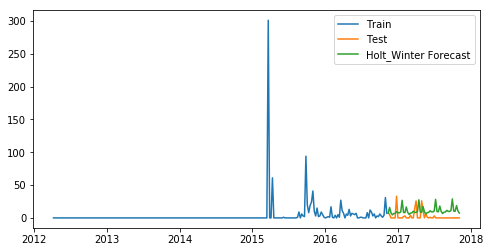

12.519632683714478

In [139]:
# Holt-Winters
# here we have trend and seasonality, so we will use Holt-Winters with Statsmodels
# additive trend and seasonality, no trend damping, seasonal periods=12
import numpy as np
from statsmodels.tsa.api import ExponentialSmoothing

fit1 = ExponentialSmoothing(np.asarray(train_df['7383']), seasonal_periods=12, 
                            trend='additive', seasonal='additive').fit(smoothing_level=0.51, 
                                                             smoothing_slope=0.015,
                                                             smoothing_seasonal=0.1)
y_hat['Holt_Winter'] = fit1.forecast(len(test_df))

# plot
plot_time_series(train_df, test_df, '7383', y_hat, 'Holt_Winter', 'Holt_Winter Forecast')

# calculate RMSE
RMSE(test_df,'7383', y_hat, 'Holt_Winter')

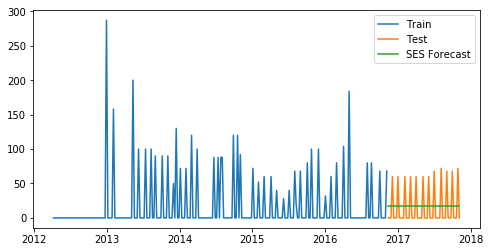

27.164006469354025

In [104]:
# Simple Exponential Smoothing
from statsmodels.tsa.api import SimpleExpSmoothing

fit2 = SimpleExpSmoothing(np.asarray(train_df['8410-17'])).fit(smoothing_level=0.1,optimized=False)
y_hat['SES'] = fit2.forecast(len(test_df))

# plot
plot_time_series(train_df, test_df, '8410-17', y_hat, 'SES', 'SES Forecast')

# calculate RMSE
RMSE(test_df,'8410-17', y_hat, 'SES')

In [140]:
# SARIMA
# gridsearch with pyramid
from pyramid.arima import ARIMA

fit = ARIMA(order=(1, 1, 0), seasonal_order=(1, 0, 0, 12)).fit(y=train_df['7383'])

from pyramid.arima import auto_arima

stepwise_fit = auto_arima(train_df['7383'], start_p=0, start_q=0, max_p=6, max_q=6, m=12,
                          start_P=0, seasonal=True, d=1, D=1, trace=True,
                          error_action='ignore',  # don't want to know if an order does not work
                          suppress_warnings=True,  # don't want convergence warnings
                          stepwise=True)  # set to stepwise

stepwise_fit.summary()

Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=2221.165, BIC=2231.440, Fit time=0.360 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=2355.694, BIC=2362.544, Fit time=0.014 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=2225.535, BIC=2239.235, Fit time=0.233 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=2077.383, BIC=2091.082, Fit time=0.328 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=2079.069, BIC=2096.193, Fit time=0.414 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=2212.155, BIC=2222.430, Fit time=0.181 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=2078.907, BIC=2096.032, Fit time=2.048 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=2080.703, BIC=2101.252, Fit time=3.201 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=2079.321, BIC=2096.446, Fit time=0.395 seconds
Fit ARIMA: order=(0, 1, 2) s

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  240
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1034.691
Date:                            Tue, 05 Jun 2018   AIC                           2077.383
Time:                                    13:43:06   BIC                           2091.082
Sample:                                         0   HQIC                          2082.911
                                            - 240                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0018      0.024     -0.074      0.941      -0.048       0.045
ma.L1         -0.9927      0.098    -10.130      0.000      -1.185      -0.801
ma.S.L12      -0.9897      0.563     -1.758      0.079      -2.093       0.114
sigma2       444.4553    240.680      1.847      0.065     -27.270     916.180
===================================================================================
Ljung-Box (Q):                       35.62   Jarque-Bera (JB):            226783.54
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):           85509.67   Skew:                            11.62
Prob(H) (two-sided):                  0.00   Kurtosis:                       156.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

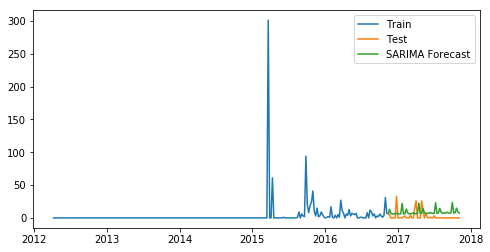

10.722801254640341

In [142]:
# fit with SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAX

fit1 = SARIMAX(train_df['7383'], order=(0, 1, 1), seasonal_order=(0,1,1,12), freq='W').fit()
y_hat['SARIMA'] = fit1.predict(start="2016-11-06", end="2017-11-05", dynamic=True, typ='levels')

# plot
plot_time_series(train_df, test_df, '7383', y_hat, 'SARIMA', 'SARIMA Forecast')

# calculate RMSE

RMSE(test_df,'7383', y_hat, 'SARIMA')

#### another product from product_type0

'7372/12',
 '7379/10',
 '7383',
 '7392',
 '7417-2',
 '7417-3',
 '7417-6',
 '7419',
 '7420',
 '7661/13',
 '7661/16',
 '7702',
 '7707',
 '7707S',
 '7712',
 '7725',
 '7726',
 '7812',
 '7990',
 '8000-3',
 '8000NL',
 '8001',
 '8010',
 '8052',
 '8052-2',
 '8150',
 '8150-1',
 '8210',
 '8220',
 '8237',
 '8238',
 '8239',
 '8275-2',
 '8310',
 '8347-3',
 '8347-33',
 '8408',
 '8408-4',
 '8408-6',
 '8410',
 '8410-17',
 '8416',
 '8418',
 '8420',
 '8462',
 '8464',
 '8477',
 '8500BK',
 '8510',
 '8511',
 '8518',
 '8525',
 '8552',
 '8562',
 '8567',
 '8590',
 '8600-25',
 '8605',
 '8605-1',
 '8605-2',
 '8606',
 '8606-1',
 '8612',
 '8616',
 '8620',
 '8625-1',
 '8642',
 '8646-3',

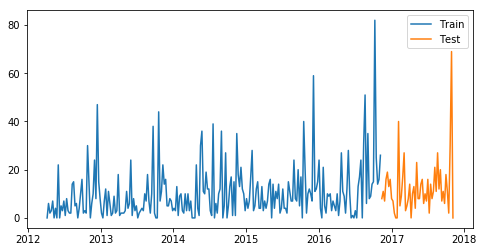

In [121]:
from functions import plot_train_test
plot_train_test(train_df, test_df, '8620')

In [122]:
# make a df to store all our predictions
from functions import make_copy_df
y_hat = make_copy_df(test_df, '8620')

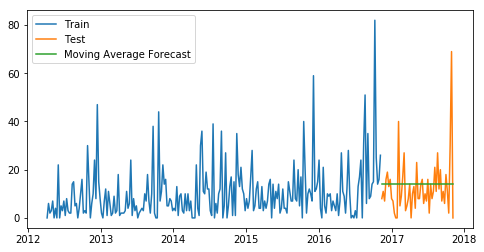

11.434790678880942

In [123]:
# baseline: Moving Average with 52
from functions import moving_average
from functions import plot_time_series
from functions import RMSE

y_hat['moving_avg'] = moving_average(train_df['8620'], m=52)

plot_time_series(train_df, test_df, '8620', y_hat, 'moving_avg', 'Moving Average Forecast')

RMSE(test_df,'8620', y_hat, 'moving_avg')

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/andreafabry/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


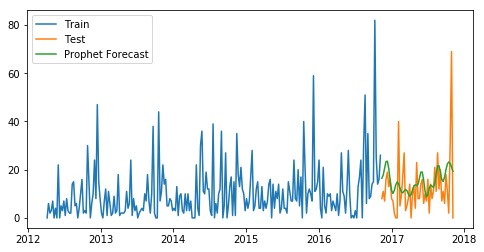

11.228112082249519

In [124]:
# FB Prophet
# imports 
from fbprophet import Prophet

# make a copy of the dataframe for Prophet transformations
from functions import make_copy_df
prophet_df = make_copy_df(train_df, '8620')

# rename variables (prophet requires the variable names in the time series to be
# y for target and ds for Datetime)
from functions import rename_columns
rename_columns(prophet_df, '8620')

# instantiate model instance and set the uncertainty interval to 95% 
# (the Prophet default is 80%)
my_model = Prophet(interval_width=0.95, weekly_seasonality=True)
# fit
my_model.fit(prophet_df)
# forecast for a year
future_dates = my_model.make_future_dataframe(periods=52, freq='W')
forecast = my_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
forecast = forecast.set_index('ds')
forecast_slice=forecast[240:292]
forecast_df = forecast_slice["yhat"]
# plot
plot_time_series(train_df, test_df, '8620', forecast_slice, 'yhat', 'Prophet Forecast')

RMSE(test_df, '8620', forecast_slice, 'yhat')

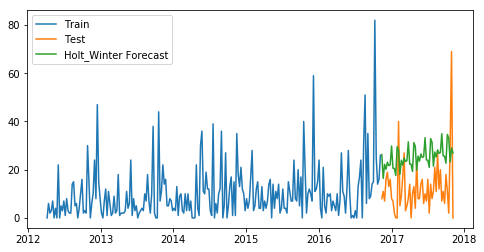

17.392430769874387

In [125]:
# Holt-Winters
# here we have trend and seasonality, so we will use Holt-Winters with Statsmodels
# additive trend and seasonality, no trend damping, seasonal periods=12
import numpy as np
from statsmodels.tsa.api import ExponentialSmoothing

fit1 = ExponentialSmoothing(np.asarray(train_df['8620']), seasonal_periods=12, 
                            trend='additive', seasonal='additive').fit(smoothing_level=0.51, 
                                                             smoothing_slope=0.015,
                                                             smoothing_seasonal=0.1)
y_hat['Holt_Winter'] = fit1.forecast(len(test_df))

# plot
plot_time_series(train_df, test_df, '8620', y_hat, 'Holt_Winter', 'Holt_Winter Forecast')

# calculate RMSE
RMSE(test_df,'8620', y_hat, 'Holt_Winter')

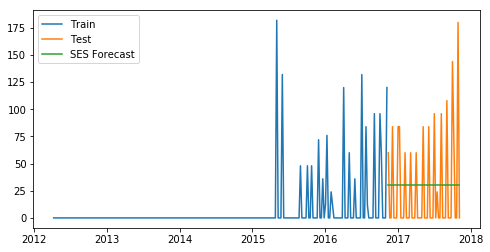

44.494835953798

In [105]:
# Simple Exponential Smoothing
from statsmodels.tsa.api import SimpleExpSmoothing

fit2 = SimpleExpSmoothing(np.asarray(train_df['8731/5'])).fit(smoothing_level=0.1,optimized=False)
y_hat['SES'] = fit2.forecast(len(test_df))

# plot
plot_time_series(train_df, test_df, '8731/5', y_hat, 'SES', 'SES Forecast')

# calculate RMSE
RMSE(test_df,'8731/5', y_hat, 'SES')

In [126]:
# SARIMA
# gridsearch with pyramid
from pyramid.arima import ARIMA

fit = ARIMA(order=(1, 1, 0), seasonal_order=(1, 0, 0, 12)).fit(y=train_df['8620'])

from pyramid.arima import auto_arima

stepwise_fit = auto_arima(train_df['8620'], start_p=0, start_q=0, max_p=6, max_q=6, m=12,
                          start_P=0, seasonal=True, d=1, D=1, trace=True,
                          error_action='ignore',  # don't want to know if an order does not work
                          suppress_warnings=True,  # don't want convergence warnings
                          stepwise=True)  # set to stepwise

stepwise_fit.summary()

Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=1913.801, BIC=1924.076, Fit time=0.159 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=2018.657, BIC=2025.507, Fit time=0.019 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=1903.430, BIC=1917.130, Fit time=0.246 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=1774.310, BIC=1788.010, Fit time=0.606 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=1776.266, BIC=1793.391, Fit time=0.975 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=1867.258, BIC=1877.533, Fit time=0.125 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=1776.264, BIC=1793.389, Fit time=1.544 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=1777.390, BIC=1797.940, Fit time=2.509 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=1776.189, BIC=1793.314, Fit time=0.510 seconds
Fit ARIMA: order=(0, 1, 2) s

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  240
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -883.155
Date:                            Tue, 05 Jun 2018   AIC                           1774.310
Time:                                    13:30:37   BIC                           1788.010
Sample:                                         0   HQIC                          1779.838
                                            - 240                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0081      0.017      0.484      0.628      -0.025       0.041
ma.L1         -0.9235      0.043    -21.567      0.000      -1.007      -0.840
ma.S.L12      -0.8997      0.069    -12.956      0.000      -1.036      -0.764
sigma2       127.0078      9.309     13.643      0.000     108.762     145.253
===================================================================================
Ljung-Box (Q):                       29.13   Jarque-Bera (JB):               593.75
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               2.02   Skew:                             2.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

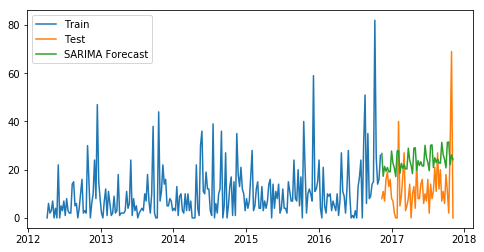

16.247906465397815

In [127]:
# fit with SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAX

fit1 = SARIMAX(train_df['8620'], order=(0, 1, 1), seasonal_order=(0,1,1,12), freq='W').fit()
y_hat['SARIMA'] = fit1.predict(start="2016-11-06", end="2017-11-05", dynamic=True, typ='levels')

# plot
plot_time_series(train_df, test_df, '8620', y_hat, 'SARIMA', 'SARIMA Forecast')

# calculate RMSE

RMSE(test_df,'8620', y_hat, 'SARIMA')

### product_type1 (more mellow)
125 items

In [111]:
product_type1

['1515',
 '1550',
 '1555',
 '1777',
 '2000',
 '2036',
 '2801-7',
 '2898',
 '2911',
 '2927-7',
 '2933',
 '4022-7',
 '4034-7',
 '4040-7/09',
 '4042-7',
 '4045-7',
 '4050-7',
 '4060-7',
 '4062-7',
 '4066-7/10',
 '4066-7/12',
 '4066/09',
 '4066/12',
 '4067-7/10',
 '4086-7/09',
 '4086-7/12',
 '4103-7',
 '4105-7',
 '4107-7',
 '4109-7',
 '4110-7',
 '4114-7/16',
 '4114-7/20',
 '4121-7',
 '4126-7',
 '4128-7',
 '4128-7/12',
 '41284-7',
 '4143-7',
 '4152-7/23',
 '4172-7',
 '4173-7',
 '4175-7',
 '4176-7',
 '4188-7',
 '4188-7/14',
 '4192-7',
 '4193-7',
 '4195-7',
 '4348',
 '4461/23',
 '4473',
 '4474/26',
 '4522-7/16',
 '4524-7/23',
 '4560-7/20',
 '4562-7/16',
 '4562-7/20',
 '4563-7/20',
 '4572-7/20',
 '4582/20',
 '4584-7/16',
 '4585-7/20',
 '4596-7/16',
 '4596-7/20',
 '4602-7',
 '4606-7/14',
 '4627WS',
 '4680/16',
 '4850-7',
 '4851-7/09',
 '4853-7/23',
 '4855-7',
 '4856-7',
 '4860-7',
 '4862-7/20',
 '4862-7/26',
 '4863-7',
 '4864-7',
 '5500',
 '5508',
 '5558-G',
 '7000',
 '7210',
 '7228/35',
 '7267

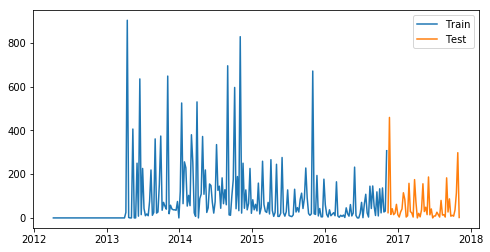

In [77]:
# plot one item
from functions import plot_train_test
plot_train_test(train_df, test_df, '4067-7/10')

In [112]:
# make a df to store all our predictions
from functions import make_copy_df
y_hat = make_copy_df(test_df, '4067-7/10')

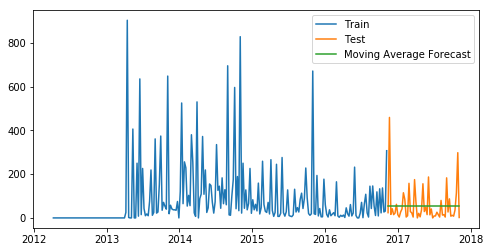

83.31835688895067

In [113]:
# baseline: Moving Average with 52
from functions import moving_average
from functions import plot_time_series
from functions import RMSE

y_hat['moving_avg'] = moving_average(train_df['4067-7/10'], m=52)

plot_time_series(train_df, test_df, '4067-7/10', y_hat, 'moving_avg', 'Moving Average Forecast')

RMSE(test_df,'4067-7/10', y_hat, 'moving_avg')

In [87]:
# SARIMA
# gridsearch with pyramid
from pyramid.arima import ARIMA

fit = ARIMA(order=(1, 1, 0), seasonal_order=(1, 0, 0, 12)).fit(y=train_df['4067-7/10'])

from pyramid.arima import auto_arima

stepwise_fit = auto_arima(train_df['4067-7/10'], start_p=0, start_q=0, max_p=6, max_q=6, m=12,
                          start_P=0, seasonal=True, d=1, D=1, trace=True,
                          error_action='ignore',  # don't want to know if an order does not work
                          suppress_warnings=True,  # don't want convergence warnings
                          stepwise=True)  # set to stepwise

stepwise_fit.summary()

Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=3118.684, BIC=3128.959, Fit time=0.279 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=3263.424, BIC=3270.274, Fit time=0.015 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=3115.053, BIC=3128.753, Fit time=0.329 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=2942.069, BIC=2955.769, Fit time=0.700 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=2945.162, BIC=2962.286, Fit time=0.950 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=3072.888, BIC=3083.163, Fit time=0.086 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=2945.137, BIC=2962.262, Fit time=1.791 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=2947.465, BIC=2968.015, Fit time=1.452 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=2936.253, BIC=2953.378, Fit time=0.944 seconds
Fit ARIMA: order=(1, 1, 0) s

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  240
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1463.126
Date:                            Mon, 04 Jun 2018   AIC                           2936.253
Time:                                    13:20:14   BIC                           2953.378
Sample:                                         0   HQIC                          2943.163
                                            - 240                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.1950      0.207     -0.944      0.345      -0.600       0.210
ar.L1         -0.1965      0.102     -1.926      0.054      -0.397       0.003
ma.L1         -0.9307      0.034    -27.479      0.000      -0.997      -0.864
ma.S.L12      -0.9927      1.182     -0.840      0.401      -3.309       1.324
sigma2      1.976e+04    2.3e+04      0.860      0.390   -2.53e+04    6.48e+04
===================================================================================
Ljung-Box (Q):                       84.80   Jarque-Bera (JB):               865.62
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.57   Skew:                             2.35
Prob(H) (two-sided):                  0.01   Kurtosis:                        11.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

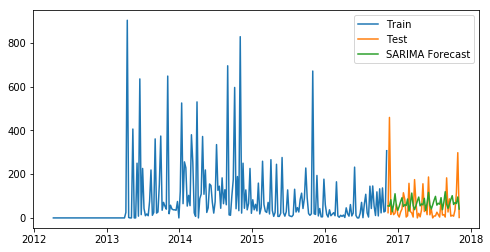

88.25479555093283

In [88]:
# fit with SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAX

fit1 = SARIMAX(train_df['4067-7/10'], order=(1, 1, 1), seasonal_order=(0,1,1,12), freq='W').fit()
y_hat['SARIMA'] = fit1.predict(start="2016-11-06", end="2017-11-05", dynamic=True, typ='levels')

# plot
plot_time_series(train_df, test_df, '4067-7/10', y_hat, 'SARIMA', 'SARIMA Forecast')

# calculate RMSE

RMSE(test_df,'4067-7/10', y_hat, 'SARIMA')

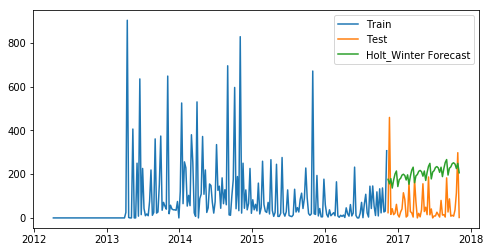

175.47626434736614

In [86]:
# Holt-Winters
# here we have trend and seasonality, so we will use Holt-Winters with Statsmodels
# additive trend and seasonality, no trend damping, seasonal periods=12
import numpy as np
from statsmodels.tsa.api import ExponentialSmoothing

fit1 = ExponentialSmoothing(np.asarray(train_df['4067-7/10']), seasonal_periods=12, 
                            trend='additive', seasonal='additive').fit(smoothing_level=0.51, 
                                                             smoothing_slope=0.015,
                                                             smoothing_seasonal=0.1)
y_hat['Holt_Winter'] = fit1.forecast(len(test_df))

# plot
plot_time_series(train_df, test_df, '4067-7/10', y_hat, 'Holt_Winter', 'Holt_Winter Forecast')

# calculate RMSE
RMSE(test_df,'4067-7/10', y_hat, 'Holt_Winter')

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/andreafabry/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


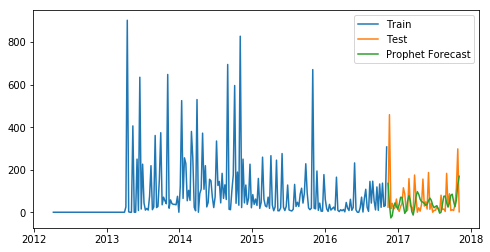

89.00384674011642

In [84]:
# FB Prophet
# imports 
from fbprophet import Prophet

# make a copy of the dataframe for Prophet transformations
from functions import make_copy_df
prophet_df = make_copy_df(train_df, '4067-7/10')

# rename variables (prophet requires the variable names in the time series to be
# y for target and ds for Datetime)
from functions import rename_columns
rename_columns(prophet_df, '4067-7/10')

# instantiate model instance and set the uncertainty interval to 95% 
# (the Prophet default is 80%)
my_model = Prophet(interval_width=0.95, weekly_seasonality=True)
# fit
my_model.fit(prophet_df)
# forecast for a year
future_dates = my_model.make_future_dataframe(periods=52, freq='W')
forecast = my_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
forecast = forecast.set_index('ds')
forecast_slice=forecast[240:292]
forecast_df = forecast_slice["yhat"]
# plot
plot_time_series(train_df, test_df, '4067-7/10', forecast_slice, 'yhat', 'Prophet Forecast')

RMSE(test_df, '4067-7/10', forecast_slice, 'yhat')

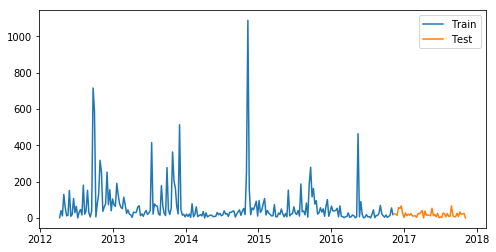

In [128]:
# plot one item
from functions import plot_train_test
plot_train_test(train_df, test_df, '4175-7')

In [129]:
# make a df to store all our predictions
from functions import make_copy_df
y_hat = make_copy_df(test_df, '4175-7')

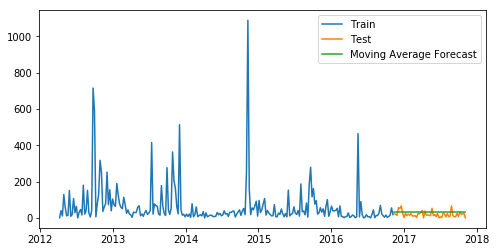

19.74380098954588

In [130]:
# baseline: Moving Average with 52
from functions import moving_average
from functions import plot_time_series
from functions import RMSE

y_hat['moving_avg'] = moving_average(train_df['4175-7'], m=52)

plot_time_series(train_df, test_df, '4175-7', y_hat, 'moving_avg', 'Moving Average Forecast')

RMSE(test_df,'4175-7', y_hat, 'moving_avg')

In [133]:
# SARIMA
# gridsearch with pyramid
from pyramid.arima import ARIMA

fit = ARIMA(order=(1, 1, 0), seasonal_order=(1, 0, 0, 12)).fit(y=train_df['4175-7'])

from pyramid.arima import auto_arima

stepwise_fit = auto_arima(train_df['4175-7'], start_p=0, start_q=0, max_p=6, max_q=6, m=12,
                          start_P=0, seasonal=True, d=1, D=1, trace=True,
                          error_action='ignore',  # don't want to know if an order does not work
                          suppress_warnings=True,  # don't want convergence warnings
                          stepwise=True)  # set to stepwise

stepwise_fit.summary()

Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=2928.992, BIC=2939.267, Fit time=0.333 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=3050.926, BIC=3057.776, Fit time=0.015 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=2965.470, BIC=2979.170, Fit time=0.284 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=2844.120, BIC=2857.820, Fit time=0.582 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=2846.022, BIC=2863.147, Fit time=0.944 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=2968.392, BIC=2978.667, Fit time=0.081 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=2846.015, BIC=2863.140, Fit time=2.001 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=2848.111, BIC=2868.660, Fit time=2.248 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 2) seasonal_orde

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  240
Model:             SARIMAX(0, 1, 2)x(0, 1, 1, 12)   Log Likelihood               -1411.469
Date:                            Tue, 05 Jun 2018   AIC                           2832.938
Time:                                    13:36:31   BIC                           2850.063
Sample:                                         0   HQIC                          2839.848
                                            - 240                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0091      0.114     -0.079      0.937      -0.233       0.215
ma.L1         -0.7269      4.656     -0.156      0.876      -9.852       8.398
ma.L2         -0.2727      1.312     -0.208      0.835      -2.845       2.300
ma.S.L12      -0.9998      4.672     -0.214      0.831     -10.157       8.158
sigma2      1.215e+04      0.000   3.13e+07      0.000    1.21e+04    1.21e+04
===================================================================================
Ljung-Box (Q):                       21.16   Jarque-Bera (JB):              9011.24
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.31   Skew:                             4.16
Prob(H) (two-sided):                  0.00   Kurtosis:                        32.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.96e+24. Standard errors may be unstable.
"""

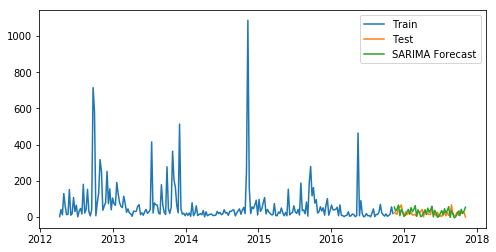

22.86753373413518

In [134]:
# fit with SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAX

fit1 = SARIMAX(train_df['4175-7'], order=(0, 1, 2), seasonal_order=(0,1,1,12), freq='W').fit()
y_hat['SARIMA'] = fit1.predict(start="2016-11-06", end="2017-11-05", dynamic=True, typ='levels')

# plot
plot_time_series(train_df, test_df, '4175-7', y_hat, 'SARIMA', 'SARIMA Forecast')

# calculate RMSE

RMSE(test_df,'4175-7', y_hat, 'SARIMA')

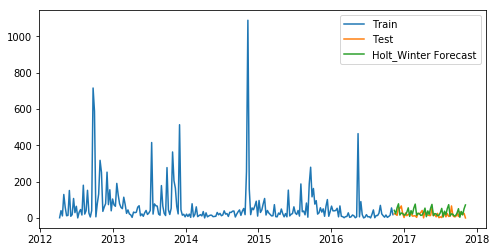

27.251587800739728

In [131]:
# Holt-Winters
# here we have trend and seasonality, so we will use Holt-Winters with Statsmodels
# additive trend and seasonality, no trend damping, seasonal periods=12
import numpy as np
from statsmodels.tsa.api import ExponentialSmoothing

fit1 = ExponentialSmoothing(np.asarray(train_df['4175-7']), seasonal_periods=12, 
                            trend='additive', seasonal='additive').fit(smoothing_level=0.51, 
                                                             smoothing_slope=0.015,
                                                             smoothing_seasonal=0.1)
y_hat['Holt_Winter'] = fit1.forecast(len(test_df))

# plot
plot_time_series(train_df, test_df, '4175-7', y_hat, 'Holt_Winter', 'Holt_Winter Forecast')

# calculate RMSE
RMSE(test_df,'4175-7', y_hat, 'Holt_Winter')

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/andreafabry/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


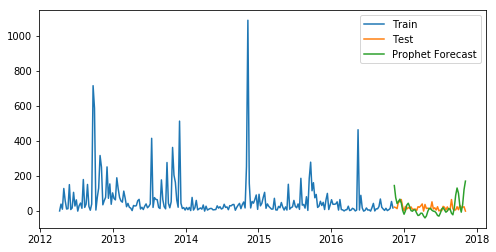

48.73805099288235

In [132]:
# FB Prophet
# imports 
from fbprophet import Prophet

# make a copy of the dataframe for Prophet transformations
from functions import make_copy_df
prophet_df = make_copy_df(train_df, '4175-7')

# rename variables (prophet requires the variable names in the time series to be
# y for target and ds for Datetime)
from functions import rename_columns
rename_columns(prophet_df, '4175-7')

# instantiate model instance and set the uncertainty interval to 95% 
# (the Prophet default is 80%)
my_model = Prophet(interval_width=0.95, weekly_seasonality=True)
# fit
my_model.fit(prophet_df)
# forecast for a year
future_dates = my_model.make_future_dataframe(periods=52, freq='W')
forecast = my_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
forecast = forecast.set_index('ds')
forecast_slice=forecast[240:292]
forecast_df = forecast_slice["yhat"]
# plot
plot_time_series(train_df, test_df, '4175-7', forecast_slice, 'yhat', 'Prophet Forecast')

RMSE(test_df, '4175-7', forecast_slice, 'yhat')

### product_type1

In [143]:
product_type1

['1515',
 '1550',
 '1555',
 '1777',
 '2000',
 '2036',
 '2801-7',
 '2898',
 '2911',
 '2927-7',
 '2933',
 '4022-7',
 '4034-7',
 '4040-7/09',
 '4042-7',
 '4045-7',
 '4050-7',
 '4060-7',
 '4062-7',
 '4066-7/10',
 '4066-7/12',
 '4066/09',
 '4066/12',
 '4067-7/10',
 '4086-7/09',
 '4086-7/12',
 '4103-7',
 '4105-7',
 '4107-7',
 '4109-7',
 '4110-7',
 '4114-7/16',
 '4114-7/20',
 '4121-7',
 '4126-7',
 '4128-7',
 '4128-7/12',
 '41284-7',
 '4143-7',
 '4152-7/23',
 '4172-7',
 '4173-7',
 '4175-7',
 '4176-7',
 '4188-7',
 '4188-7/14',
 '4192-7',
 '4193-7',
 '4195-7',
 '4348',
 '4461/23',
 '4473',
 '4474/26',
 '4522-7/16',
 '4524-7/23',
 '4560-7/20',
 '4562-7/16',
 '4562-7/20',
 '4563-7/20',
 '4572-7/20',
 '4582/20',
 '4584-7/16',
 '4585-7/20',
 '4596-7/16',
 '4596-7/20',
 '4602-7',
 '4606-7/14',
 '4627WS',
 '4680/16',
 '4850-7',
 '4851-7/09',
 '4853-7/23',
 '4855-7',
 '4856-7',
 '4860-7',
 '4862-7/20',
 '4862-7/26',
 '4863-7',
 '4864-7',
 '5500',
 '5508',
 '5558-G',
 '7000',
 '7210',
 '7228/35',
 '7267

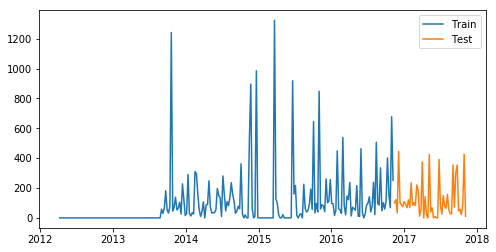

In [144]:
# plot one item
from functions import plot_train_test
plot_train_test(train_df, test_df, '2911')

# make a df to store all our predictions
from functions import make_copy_df
y_hat = make_copy_df(test_df, '2911')

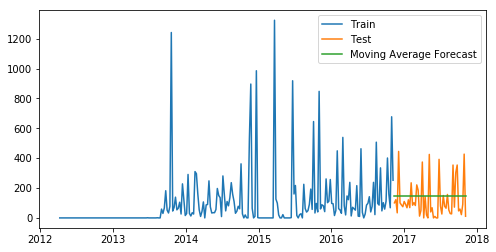

127.47965233853999

In [145]:
# baseline: Moving Average with 52
from functions import moving_average
from functions import plot_time_series
from functions import RMSE

y_hat['moving_avg'] = moving_average(train_df['2911'], m=52)

plot_time_series(train_df, test_df, '2911', y_hat, 'moving_avg', 'Moving Average Forecast')

RMSE(test_df,'2911', y_hat, 'moving_avg')

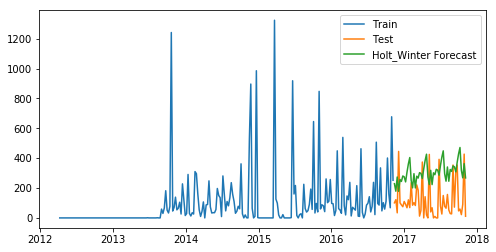

235.80538013432607

In [146]:
# Holt-Winters
# here we have trend and seasonality, so we will use Holt-Winters with Statsmodels
# additive trend and seasonality, no trend damping, seasonal periods=12
import numpy as np
from statsmodels.tsa.api import ExponentialSmoothing

fit1 = ExponentialSmoothing(np.asarray(train_df['2911']), seasonal_periods=12, 
                            trend='additive', seasonal='additive').fit(smoothing_level=0.51, 
                                                             smoothing_slope=0.015,
                                                             smoothing_seasonal=0.1)
y_hat['Holt_Winter'] = fit1.forecast(len(test_df))

# plot
plot_time_series(train_df, test_df, '2911', y_hat, 'Holt_Winter', 'Holt_Winter Forecast')

# calculate RMSE
RMSE(test_df,'2911', y_hat, 'Holt_Winter')

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/andreafabry/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


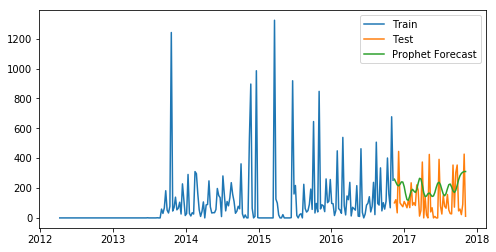

155.5275641433786

In [147]:
# FB Prophet
# imports 
from fbprophet import Prophet

# make a copy of the dataframe for Prophet transformations
from functions import make_copy_df
prophet_df = make_copy_df(train_df, '2911')

# rename variables (prophet requires the variable names in the time series to be
# y for target and ds for Datetime)
from functions import rename_columns
rename_columns(prophet_df, '2911')

# instantiate model instance and set the uncertainty interval to 95% 
# (the Prophet default is 80%)
my_model = Prophet(interval_width=0.95, weekly_seasonality=True)
# fit
my_model.fit(prophet_df)
# forecast for a year
future_dates = my_model.make_future_dataframe(periods=52, freq='W')
forecast = my_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
forecast = forecast.set_index('ds')
forecast_slice=forecast[240:292]
forecast_df = forecast_slice["yhat"]
# plot
plot_time_series(train_df, test_df, '2911', forecast_slice, 'yhat', 'Prophet Forecast')

RMSE(test_df, '2911', forecast_slice, 'yhat')

In [148]:
# SARIMA
# gridsearch with pyramid
from pyramid.arima import ARIMA

fit = ARIMA(order=(1, 1, 0), seasonal_order=(1, 0, 0, 12)).fit(y=train_df['2911'])

from pyramid.arima import auto_arima

stepwise_fit = auto_arima(train_df['2911'], start_p=0, start_q=0, max_p=6, max_q=6, m=12,
                          start_P=0, seasonal=True, d=1, D=1, trace=True,
                          error_action='ignore',  # don't want to know if an order does not work
                          suppress_warnings=True,  # don't want convergence warnings
                          stepwise=True)  # set to stepwise

stepwise_fit.summary()

Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=3217.558, BIC=3227.833, Fit time=0.393 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=3375.359, BIC=3382.209, Fit time=0.016 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=3218.254, BIC=3231.954, Fit time=0.350 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=3066.635, BIC=3080.335, Fit time=0.516 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=3068.550, BIC=3085.674, Fit time=0.924 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=3193.156, BIC=3203.431, Fit time=0.106 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=3068.557, BIC=3085.682, Fit time=1.912 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=3075.770, BIC=3096.319, Fit time=1.600 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=3068.562, BIC=3085.687, Fit time=0.859 seconds
Fit ARIMA: order=(0, 1, 2) s

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  240
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1529.317
Date:                            Tue, 05 Jun 2018   AIC                           3066.635
Time:                                    13:47:55   BIC                           3080.335
Sample:                                         0   HQIC                          3072.163
                                            - 240                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0814      0.088     -0.925      0.355      -0.254       0.091
ma.L1         -1.0000      2.311     -0.433      0.665      -5.530       3.530
ma.S.L12      -0.9975      2.333     -0.428      0.669      -5.570       3.575
sigma2      3.444e+04   6.34e-05   5.43e+08      0.000    3.44e+04    3.44e+04
===================================================================================
Ljung-Box (Q):                       75.39   Jarque-Bera (JB):              2536.26
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.18   Skew:                             3.39
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

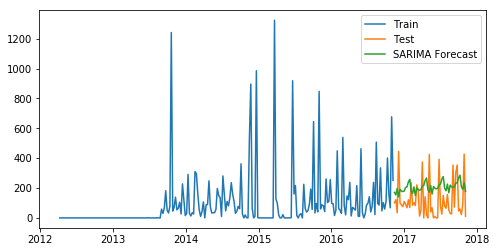

155.8157789095979

In [149]:
# fit with SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAX

fit1 = SARIMAX(train_df['2911'], order=(0, 1, 1), seasonal_order=(0,1,1,12), freq='W').fit()
y_hat['SARIMA'] = fit1.predict(start="2016-11-06", end="2017-11-05", dynamic=True, typ='levels')

# plot
plot_time_series(train_df, test_df, '2911', y_hat, 'SARIMA', 'SARIMA Forecast')

# calculate RMSE

RMSE(test_df,'2911', y_hat, 'SARIMA')